In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import idct

Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    DCT[:, i] = temp/norm


Generating the 1-D standard basis

In [4]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

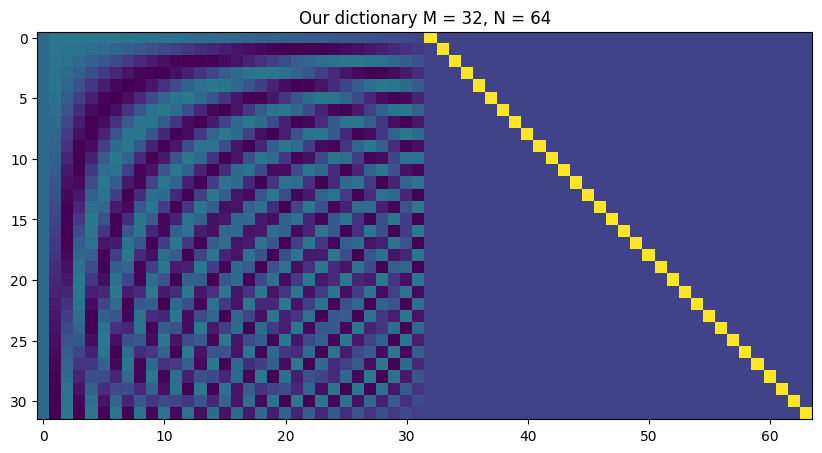

In [5]:
D = np.hstack((DCT, C)) # A = np.concatenate((C, D), axis=1)

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [7]:
x0 = np.zeros(N)
positions = np.random.choice(M, L, replace=False)
x0[positions] = np.random.rand(L)
x0

array([0.84638686, 0.        , 0.        , 0.7188988 , 0.        ,
       0.        , 0.75983241, 0.        , 0.        , 0.        ,
       0.        , 0.85859332, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09211591, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])



Choose spike location and update x0

In [8]:
# choose random position from M to N (N = 2M)
spikeLocation = np.random.choice(M) + M # from 32 to 64
print(spikeLocation)
#add spike to x0
x0[spikeLocation] = 4*np.abs(max(x0)) # this is to make the spike at least 4 times bigger than the biggest magnitude on signal
x0

42


array([0.84638686, 0.        , 0.        , 0.7188988 , 0.        ,
       0.        , 0.75983241, 0.        , 0.        , 0.        ,
       0.        , 0.85859332, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09211591, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.43437327, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
# s0 = Dx
s0 = D @ x0 # noise free

# add noise
sigma_noise = sigma_noise * (np.random.normal(size=s0.shape))

# s = s0 + eta
s = s0 + sigma_noise

In [10]:
s0

array([ 7.06083719e-01,  3.99480044e-01,  1.11860779e-01, -7.86456534e-04,
        3.81104792e-02,  1.49367527e-01,  1.23864849e-01, -7.75318364e-02,
       -1.60602636e-01,  5.67981998e-03,  3.66135004e+00,  3.35988177e-01,
        2.32025839e-01, -7.69746652e-02, -2.84705140e-01, -1.56085269e-01,
        1.17359502e-01,  2.97758833e-01,  3.47964770e-01,  2.84604152e-01,
        2.60015157e-01,  4.41367512e-01,  6.32415283e-01,  5.44541004e-01,
        2.40902500e-01, -7.31281384e-02, -2.37196848e-01, -1.12219503e-01,
        1.59233931e-01,  2.33605926e-01,  9.56062248e-02, -1.76952085e-02])

Plot the sparse signal

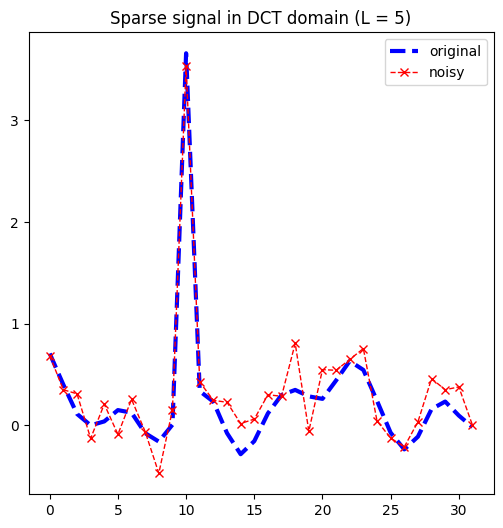

In [11]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [12]:
x_MP = np.zeros(N)

r = s - (D @ x_MP)
print(r)
print(r.shape)
l = 1 # cont

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r)

MINIMUM_RES_NORM = 0.1

[ 6.85173291e-01  3.49678723e-01  3.09721680e-01 -1.29118043e-01
  2.07708302e-01 -8.99410173e-02  2.55727072e-01 -6.32842764e-02
 -4.72445027e-01  1.51729073e-01  3.53742139e+00  4.25716994e-01
  2.45397778e-01  2.26453426e-01  1.69769380e-02  6.07222776e-02
  3.00359226e-01  2.85264145e-01  8.06214781e-01 -5.80573247e-02
  5.47717580e-01  5.41203407e-01  6.48059301e-01  7.55012733e-01
  4.25077670e-02 -1.26009657e-01 -2.12592916e-01  3.31224595e-02
  4.59084551e-01  3.49902211e-01  3.77420497e-01  1.11054540e-03]
(32,)


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [13]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:
    print(f"Cycle:{l}")

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        zj = (r.T @ dj) / np.linalg.norm(dj) # dot product between 2 vectors = escalar
        e[j] = np.linalg.norm(r)**2 - zj**2 
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized

    # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
    jStar = np.argmin(e) # index where the minimum value of e is located

    # find zjStar and djStar
    djStar = D[:,jStar]
    zjStar = (r.T @ djStar) / np.linalg.norm(djStar)**2 # same as zj but just square the denominator
    
    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    x_MP[jStar] = x_MP[jStar] + zjStar

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - (D @ x_MP)
    # r = r - (zjStar*djStar) - s # component that cannot be captured by the signal (the signal at the very beginning)

    l = l + 1

    # update the residual norm
    resNorm = np.linalg.norm(r)
    print()

Cycle:1

Cycle:2

Cycle:3

Cycle:4

Cycle:5



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [14]:
s_hat_MP = D @ x_MP
s_hat_MP

array([ 7.28287011e-01,  4.58917466e-01,  1.53803023e-01,  4.69668984e-02,
        1.48607339e-01,  2.59685048e-01,  2.02146518e-01,  1.56701424e-02,
       -8.89063926e-02,  3.23303515e-02,  3.82192826e+00,  4.17390668e-01,
        2.82081963e-01, -7.55775351e-03, -1.80856699e-01, -7.69079796e-02,
        2.02801388e-01,  4.10317128e-01,  4.09243843e-01,  3.02437912e-01,
        2.98945021e-01,  4.68196718e-01,  6.49035035e-01,  6.15272780e-01,
        3.24280533e-01, -1.71948426e-02, -1.46071577e-01,  1.37403320e-03,
        2.34830288e-01,  3.10827949e-01,  1.77939167e-01,  1.21366428e-02])

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [15]:
resNorm_MP = np.linalg.norm(r)


Show the result

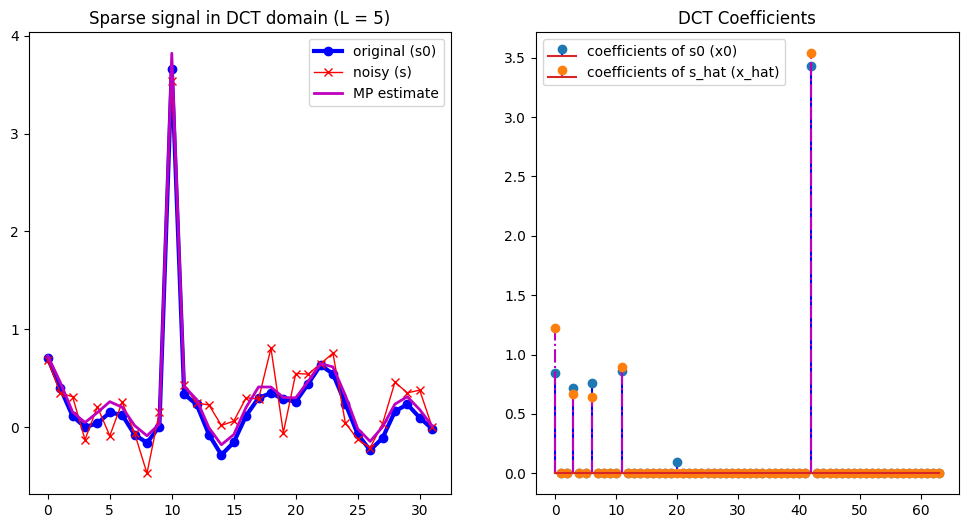

In [16]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

